## Yair Cohen Selaya 302599816

**Intro to Data Science Project Extension, HIT, 2020**
# UFC Events Popularity & Revenue<br><br>

# Table Of Content

- **Import packages**

## Section 1 -  Scraping the Data into pandas DataFrames:
1. **Web scraping Part 1 - Tickets Revenue, PayPerView Buyrate & TV Ratings Average - Steps:**
    1. Connecting the WebDriver and filtering the Events index dynamically
    2. Scraping each Event's url from the filtered index
    3. Scraping the Events data from each event url <br><br>
    4. Data Refinement:
        >A. Splitting the data items<br>
         B. Handling the date form to be left with numeric date only<br>
         C. Handling data items which are still in one list item - seperated by pipe '|'<br>
         D. Excluding all irrelevant data<br>
         E. Excluding Event lists which has only 1 data item left after step D.<br>
    

2. **Web Scraping Part 2 - Top 50 MMA (UFC) Athletes by Networh - Steps:**<br><br>
   1. Reconnecting the WebDriver and requesting the URL
   2. Scraping the data
   3. Data Refinement
   4. Converting the data from list of lists into pd.DataFrame


3.**Manual scraping - PayPerView Average Price by Year**
 >1. Inserting the data into list of tuples


## Section 2 - Exploratory Data Analysis:

1. UFC Events Popularity Revenue by the Different Weight Classes
2. UFC's Revenue from Tickets and PPV buys, through the career of 3 Champions - through different Weight Classes
3. Calculating the Total Revenue each Champion has produced for the UFC
4. The Champions Networth

## Section 3:
1. **Summary**
2. Writing the scraped data to csv files

- **Import Packages**

In [1]:
# Web scraping
from selenium.webdriver import Chrome
from selenium.webdriver import ActionChains
from selenium.webdriver.support.select import Select

from time import sleep
from random import randint

# Formatting
import locale
import datetime

# EDA & Visualization
import pandas as pd
from numpy import mean
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Web Scraping Part 1:
### Attendance, Tickets Revenue, PayPerView Buyrate and TV Ratings Average
The following website - https://www.tapology.com/fightcenter gathers these statistics, not only for the UFC but for more MMA events.<br>

Therefore We will have to first filter the index results, for past UFC events. <br>
**Step 1:** <br>
>Since the filter bar is a dynamic JavaScript object, We will use Selenium ChromeWebDriver to filter the index by clicking the JS dropdown list.<br>

**Step 2:** <br>
>After We got the relevant events index, We will have to scrape each Event's url seperatley. We will have to navigate through the filtered index untill We got to it's last page.<br>

**Step 3:** <br>
>Once We'll have a list of all Event's urls (which contains the relevant data for a single event),<br>
We'll scrape the data from each one of them.<br>

**Step 4:** <br>
>Data refinement - excluding irrelevant data, handling null values, generalize different forms of the same data, converting numeric values to numeric types and so on, so the data will be ready to be converted to pandas.DataFrame object<br>

## Step 1 - Connecting the WebDriver and filtering the Events index dynamically

In [2]:
# Connecting the Selenium Chrome WebDriver
driver = Chrome(executable_path='/usr/local/bin/chromedriver')

# Requesting the web page
driver.get("https://www.tapology.com/fightcenter/")

# Sleep for assertion the content was loaded
sleep(randint(3,5))

In [3]:
## Note: For some reason, when filtering the 2 parameters: 'UFC', Results' through the JS dropdown lists
## the index's content is not being refreshed, it maybe due to recognition of the WebDriver. 
## The walkaround I found is to first filter the 'UFC' parameter by clicking an ordinary href over the 'Quick Filter',
## and only then filtering the 'Result' parameter through the JS dropdown (which exsits only at the dropdown)
## Wierdly enough, after that the content is being loaded

# Filtering of UFC Fights by clicking an href
driver.find_element_by_xpath('//*[@id="content"]/p/span/a[3]').click()

# Dynamic filtering by clicking the JS dropdown list - 'Results' parameter for past events index
dropdown_results = driver.find_element_by_xpath('//*[@id="searchRefine"]/ul/li[2]/select')

# Action chain: Click, selection, click
actions = ActionChains(driver)
actions.click(dropdown_results)
select_box_results = Select(dropdown_results)
actions.click(select_box_results.select_by_value('results'))
actions.perform()

## Step 2 - Scraping each Event's url from the filtered index

For that let's write 2 functions - 
1. For the extraction the Event's urls out of each index page.
2. For navigation to the next index page.

In [4]:
### Function for extraction of all relevant URLs from an Index page

def urlsExtractor(driver_, linksList, pageNumber):
    
    try:
        # Sleep is necessary to assert the content has been loaded before trying to find all hrefs 
        sleep(randint(2,4))
        # Find all hrefs in page
        hrefs = driver_.find_elements_by_xpath("//a[@href]")
        
        for link in hrefs:
            # Filter only relevant links by prefix
            if '/fightcenter/events/' in link.get_attribute("href"):
                linksList.append(link.get_attribute("href"))
            else:
                continue
    
    except:
        # Failure notification with page number
        print('Failed to scrape events links from page #' + pageNumber)
    
    
    finally:
        # Returns a list of all urls from current index page
        return linksList

In [5]:
### Function for navigation to the next Index page

def nextPage(driver_):
    
    try:
        # Finding 'Next' button
        driver_.find_element_by_css_selector('#content > div.fightcenterEvents > h3:nth-child(27) > span.moreLink > nav > span.next').click()
        return True
    
    except:
        # If not found return a false flag since it is the last index page
        return False

Let's use the 2 functions to get a list of all Events URLs we need to scrape:

In [6]:
# False flag will indicate we arrived the index's last page
flag = True

# Counter will indicate page number in case of failure
pagesCounter = 0
urls2Scrape = []

while flag is True:
    
    urlsExtractor(driver, urls2Scrape, pagesCounter)
    pagesCounter += 1
    flag = nextPage(driver)

## Step 3: Scraping the Events data from each event url
For that We'll write a function that returns each scraped page's data in a list

In [7]:
### Function for scraping an Event webpage - the data we're looking for

def scrapeEventStats2List(driver_, url, numOf_ScrapedPages, numOf_MissingPages):
    
    driver_ .get(url)
  # print(url)
    
    # List for the event's data
    pageSats = []
    
    try:
        
        sleep(randint(1,2))
        
        # Finding the web elements conataining the data
        stats = driver_.find_elements_by_xpath('//*[@id="content"]/div[4]/div[2]/ul')
        
        # Appending the explicit data (text)
        # Also counting succssefull \ failed attempts
        for item in stats:
            pageSats.append(item.text)
        numOf_ScrapedPages += 1
        
    except:
        
        print('Failed to scrape webpage')
        numOf_MissingPages += 1
    
    
    return (pageSats, numOf_ScrapedPages, numOf_MissingPages)

**Let's use the above 'scrapeEventStats2List' function to scrape each Event's url**<br>
Finally it prints out the total success rate

In [8]:
# Connecting a new WebDrivier
driver2 = Chrome(executable_path='/usr/local/bin/chromedriver')

# Counters 
numOfScrapedPages = 0
numOfMissingPages = 0

allScrapedPagesData = []

for url in urls2Scrape:
    
    eventPageData = scrapeEventStats2List(driver2, url, numOfScrapedPages, numOfMissingPages)
    allScrapedPagesData.append(eventPageData[0])
    numOfMissingPages = eventPageData[2]
    numOfScrapedPages = eventPageData[1]
    
print('Total of ' + str(numOfScrapedPages) + ' were successfully scraped out of ' + str(numOfScrapedPages + numOfMissingPages) + ' pages')

Total of 681 were successfully scraped out of 681 pages


## Step 4: Data Refinement
**A. Splitting the data items**

In [9]:
## Each Event's data was scraped as one list long list
print('Before: ' + '\n')
print(allScrapedPagesData[5])
print('\n')

Before: 

['Saturday 02.08.2020 at 10:00 PM ET\nU.S. Broadcast: Pay Per View | Prelims: ESPN\nPromotion: Ultimate Fighting Championship\nOwnership: WME-IMG\nVenue: Toyota Center\nLocation: Houston, Texas, United States\nEnclosure: Octagon\nTV Announcers: Jon Anik, Joe Rogan, Dominick Cruz\nRing Announcer: Bruce Buffer\nPost-Fight Interviews: Joe Rogan\nTicket Revenue (live gate): $3,549,418\nAttendance: 17,401\nPPV Buys / Buyrate: N/A | TV Ratings: 1.49M avg. viewers (ESPN prelims)\nMMA Bouts: 12\nPromotion Links:\nEvent Links:']




In [10]:
# Let's handle it by splitting the list to items per '\n'

allEventsStats_refined = []

# First let's split each event's data into a separate list item
for eventData in allScrapedPagesData:
    for dataPiece in eventData:
        allEventsStats_refined.append(dataPiece.split('\n'))
        
print('After: ' + '\n')
print(allEventsStats_refined[5])

After: 

['Saturday 02.08.2020 at 10:00 PM ET', 'U.S. Broadcast: Pay Per View | Prelims: ESPN', 'Promotion: Ultimate Fighting Championship', 'Ownership: WME-IMG', 'Venue: Toyota Center', 'Location: Houston, Texas, United States', 'Enclosure: Octagon', 'TV Announcers: Jon Anik, Joe Rogan, Dominick Cruz', 'Ring Announcer: Bruce Buffer', 'Post-Fight Interviews: Joe Rogan', 'Ticket Revenue (live gate): $3,549,418', 'Attendance: 17,401', 'PPV Buys / Buyrate: N/A | TV Ratings: 1.49M avg. viewers (ESPN prelims)', 'MMA Bouts: 12', 'Promotion Links:', 'Event Links:']


**B. Handling the date form to be left with numeric date only<br>
C. Handling data items which are still in one list item - seperated by pipe '|'<br>
D. Excluding all irrelevant data<br>
E. Excluding Event lists which has only 1 data item left after step D.<br>**

In [11]:
## Data refinement part 1: Rearranging the data in lists 

for eventStats in allEventsStats_refined:
    
    # Date came in form of: 'Friday 05.08.2020 at 05:30 AM ET'
    # Lets exclude everything but the date and give it it's field name
    # Then convert date format to to m-d-Y to match the UFC_df DataFrame datetime format
    date = eventStats[0].split(' at')[0].split(' ')[1]
    currentFormat_date = datetime.datetime.strptime(date, '%m.%d.%Y')
    newFormat_date = datetime.date.strftime(currentFormat_date, "%Y-%m-%d")
    date = 'Date: ' + newFormat_date
    eventStats[0] = date
    
    
    for dp in eventStats:
        
        # After the splitting of items, still the PPV Buys and TV Ratings are in one string
        # Let's seperate the both and append back to the event's stats list
        if ' | ' in dp:
            eventStats.append(dp.split(' | ')[0])
            eventStats.append(dp.split(' | ')[1])
            eventStats.remove(dp)

            
# For some reason not all fields containing pipe | is being removed at first attempt            
for eventStats in allEventsStats_refined:
    for dp in eventStats:
        if ' | ' in dp:
            eventStats.append(dp.split(' | ')[0])
            eventStats.append(dp.split(' | ')[1])
            eventStats.remove(dp)



# Excluding all irrelevant data fields
stats2Exclude = ['Name: ','MMA Bouts:','Also Known As: ','Ownership: ','Venue: ','Location:','Enclosure: ','Announcers:','Announcer:','Matchmaker:','Post-Fight','Promotion: ','Links:','Broadcast:', 'Backstage:', 'Interviews', 'Prelims'] 
itemBuff = []
listBuff = []

for eventStats in allEventsStats_refined:
    for dp in eventStats:
        
        if any(ext in dp for ext in stats2Exclude):
            continue
        else:
            itemBuff.append(dp)
            
    listBuff.append(itemBuff)
    itemBuff = []

allEventsStats_refined = listBuff



# Removing all useless data of events conating only one data field
listBuff = []

for eventStats in allEventsStats_refined:
    if len(eventStats) == 1:
        continue
    else:
        listBuff.append(eventStats)

allEventsStats_refined = listBuff

### Let's take a look now

In [12]:
print(allEventsStats_refined[5])

['Date: 2020-02-08', 'Ticket Revenue (live gate): $3,549,418', 'Attendance: 17,401', 'PPV Buys / Buyrate: N/A', 'TV Ratings: 1.49M avg. viewers (ESPN prelims)']


**F. Converting Event's list of lists to list of dictionaries**
>Besides easier access, also it is convinient for conversion to pandas DataFrame

**G. Data forms rifinement to be uniformed**
1. Empty strings or N/A values - Across all parameters
2. **Ticket Revenue** - comes in forms of:<br>

>$4,095,235 USD 

>$4,095,235

>$4.1M

>$1,102,542.16

3. **'PPV Buys'** - comes in forms of:<br>

>$15,077  

>$15,077 (Paid

4. **'Attendance'** - comes in forms of:<br>

>$7,055 

>$7,055 (Paid 

6. **'TV Ratings Average'**  - comes in forms of:<br>

>$870k avg. viewers (FS1 prelims, 1.37M peak)

>$1.15M avg. viewers (FS1 prelims, 1.46M peak)

>$760,000,000 avg. viewers (FS1 prelims, 1.46M peak)

>$2.5M average viewers (3.33M peak, 521k FS1 prelims)

>$1.85 million average viewers (2.5M peak)

>$21.3M average viewers

>$690,500,000 average viewers

>$991,000 viewers (average)

>$1.4M viewers (Spike)

>$2,600,000 viewers(3,400,000 peak)

In [13]:
# setting locale, used for take of commas out of numeric strings before float conversion
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' )

allEventsListOfDicts = []
dictBuff = dict()

for eventStats in allEventsStats_refined:
    for dp in eventStats:
        
        # Flags to indicate successfull \ failed split
        # Also a (True keyFlag, False valueFlag) indicates missing value
        keyFlag = True
        valFlag = True
        
        # Key split
        try:     
            key = dp.split(':')[0]
        except:
            keyFlag = False
        
        # Value split
        try:
            value = dp.split(':')[1].lstrip(' ')
        except:
            valFlag = False
        
        # Existing value - refine and set to dict
        if keyFlag & valFlag == True:
            
            # Replacing missing values with NaN
            if value == 'N/A' or '':
                value = float('NaN')
            else:
                sample = value
                
        # Custom refinement for each data field:
            # Ticket Revenue ->            
            if key == 'Ticket Revenue (live gate)':
                try:
                    # Removing $ which is prefix for all value forms
                    value = value.split('$')[1].lstrip()

                    if 'USD' in value:
                        # handling form of '4,095,235 USD'
                        value = float(locale.atoi(value.split(' USD')[0]))
                            
                    elif '.' in value:

                        if 'M' in value:
                            # handling form of '1.333M'
                            value = float(value.split('M')[0])*1000000

                        else:
                            # handling form of '1,102,542.16'
                            value = float(locale.atoi(value.split('.')[0]))
                    else:
                         value = float(locale.atoi(value))
                
                except:
                    print('Conversion failed, NaN assigned - Ticket Revenu: ' + str(sample))
                    value = float('NaN')              
            
            # PPV Buys / Buyrate ->        
            elif key == 'PPV Buys / Buyrate':
                try:
                    if ' (Paid' in value:
                        # handling single occurence of '15,077 (Paid'
                        value = float(locale.atoi(value.split(' (P')[0]))
                    else:
                        value = float(locale.atoi(value))
                        
                
                except:
                    print('Conversion failed, NaN assigned - PPV Buys / Buyrate: ' + str(sample))
                    value = float('NaN')                   
                    

            # Attendance ->
            elif key == 'Attendance':
                try:
                    # hadnling form of '7,055 (Paid'
                    value = float(locale.atoi(value.split(' ')[0]))         
                
                except:
                    print('Conversion failed, NaN assigned - TV Attendance: ' + str(sample))
                    value = float('NaN') 

            
            # TV Ratings ->
            elif key == 'TV Ratings':
                try:
                    
                    if ' avg.' in value:
                        # initial handling of form containing 'avg.'
                        value = value.split('avg.')[0]
                        
                        if 'k ' in value:
                            # handling form of '870k avg. viewers (FS1 prelims, 1.37M peak)'
                            value = float(value.split('k ')[0])*100000
                        
                        elif 'M' in value:
                            # handling form of '1.15M avg. viewers (FS1 prelims, 1.46M peak)'
                            value = float(value.split('M')[0])*1000000
                        
                        else:
                            # handling form of '760,000,000 avg. viewers (FS1 prelims, 1.46M peak)'
                            value = float(locale.atoi(value))

                    elif 'average' in value:
                        # handling form of '2.5M average viewers (3.33M peak, 521k FS1 prelims)
                        value = value.split(' average')[0]
                        
                        if 'million' in value:
                            # handling form of '1.85 million average viewers (2.5M peak)'
                            value = float(value.split('million')[0])*1000000
                        
                        elif 'M' in value:
                            # handling form of '21.3M average viewers'
                            value = float(value.split('M')[0])*1000000
                        
                        else:
                            # handling form of '690,500,000 average viewers'
                            value = float(locale.atoi(value))
                        
                    elif 'viewers' in value:
                        # handling form of '991,000 viewers (average)'
                        value = value.split(' viewers')[0]
                        
                        if 'M' in value:
                            # handling form of '1.4M viewers (Spike)'   
                            value = float(value.split('M')[0])*1000000
                        else:
                            # handling form of '2,600,000 viewers(3,400,000 peak)'
                            value = float(locale.atoi(value))

                except:
                    print('Conversion failed, NaN assigned - TV Ratings: ' + str(sample))
                    value = float('NaN') 

                    
            dictBuff[key] = value
        
        # Missing value - set NaN to dcit
        elif keyFlag == True & valFlag == False:
            dictBuff[key] = float('NaN')
                   
    allEventsListOfDicts.append(dictBuff)
    dictBuff = dict()

Conversion failed, NaN assigned - PPV Buys / Buyrate: 15,077 (Paid
Conversion failed, NaN assigned - PPV Buys / Buyrate: 17,401
Conversion failed, NaN assigned - PPV Buys / Buyrate: 16,811
Conversion failed, NaN assigned - PPV Buys / Buyrate: 20,143
Conversion failed, NaN assigned - PPV Buys / Buyrate: 57,127
Conversion failed, NaN assigned - PPV Buys / Buyrate: 2019-09-07
Conversion failed, NaN assigned - PPV Buys / Buyrate: 17,304
Conversion failed, NaN assigned - PPV Buys / Buyrate: 12,144
Conversion failed, NaN assigned - PPV Buys / Buyrate: 18,358
Conversion failed, NaN assigned - PPV Buys / Buyrate: 16,083
Conversion failed, NaN assigned - PPV Buys / Buyrate: 15,193
Conversion failed, NaN assigned - TV Ratings: 991,000 viewers (average)
Conversion failed, NaN assigned - PPV Buys / Buyrate: 9,000


In [14]:
# For unknown reason some previous conversion attempts didn't raise it's exception, But neither it was a successful
# without this re-conversion the df will be missing some values
# as they failing to be converted to float64 pd datatype

for dct in allEventsListOfDicts:
    for key, value in dct.items():
        if key == 'Ticket Revenue (live gate)':
            try:
                temp = value.replace(',', '')
                dct[key] = float(temp)
            except:
                continue
        elif key == 'PPV Buys / Buyrate':
            try:
                temp = value.replace(',', '')
                dct[key] = float(temp)
            except:
                continue
        elif key == 'Attendance':
            try:
                temp = value.replace(',', '')
                dct[key] = float(temp)
            except:
                continue
        elif key == 'TV Ratings':
            try:
                temp = value.replace(',', '')
                dct[key] = float(temp)
            except:
                continue

## Convert List of dictionaries into pd.DataFrame

In [15]:
# List of new column names
colNames = ['attendance', 'date', 'ppv_buys', 'tv_ratings_avg', 'tickets_revenue']

# Converting list of dicts to DataFrame
UFC_EventsRevenue_df = pd.DataFrame(allEventsListOfDicts)

# Renaming the columns with the new names
UFC_EventsRevenue_df.columns = colNames

# Rearranging the order of the columns
UFC_EventsRevenue_df = UFC_EventsRevenue_df[['date', 'attendance', 'tickets_revenue', 'ppv_buys', 'tv_ratings_avg']]

# Converting numeric columns from object type to float
cols2Convert = ['attendance', 'ppv_buys', 'tv_ratings_avg', 'tickets_revenue']
UFC_EventsRevenue_df[cols2Convert] = UFC_EventsRevenue_df[cols2Convert].apply(pd.to_numeric, errors='coerce')

In [16]:
UFC_EventsRevenue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 5 columns):
date               481 non-null object
attendance         452 non-null float64
tickets_revenue    367 non-null float64
ppv_buys           194 non-null float64
tv_ratings_avg     287 non-null float64
dtypes: float64(4), object(1)
memory usage: 18.9+ KB


In [17]:
UFC_EventsRevenue_df.head()

,date,attendance,tickets_revenue,ppv_buys,tv_ratings_avg
0,2020-03-14,NaN,NaN,NaN,672000.0
1,2020-03-07,15077.0,2742906.0,NaN,1190000.0
2,2020-02-29,7098.0,402958.0,NaN,NaN
3,2020-02-22,10025.0,1239625.0,NaN,NaN
4,2020-02-15,6449.0,596820.0,NaN,NaN


## 2. Web Scraping Part 2:
### Top 50 MMA (UFC) Athletes by Networh
From the following webpage - https://www.celebritynetworth.com/list/top-50-mma-net-worth/ <br>
**Step 1:** <br>
>Reconnecting the WebDriver and requesting the URL<br>

**Step 2:** <br>
>Scraping the data<br>

**Step 3:** <br>
>Data Refinement<br>

**Step 4:** <br>
>Converting the data from list of lists into pd.DataFrame<br>

### Step 1: Reconnecting the WebDriver and Requesting the URL

In [18]:
# Reconnecting the driver
driver = Chrome(executable_path='/usr/local/bin/chromedriver')

# Requesting the url
driver.get("https://www.celebritynetworth.com/list/top-50-mma-net-worth/")

### Step 2: Scraping the data using xPath

In [19]:
# Scrape list of data - all data came in form of one long string
athletesNetworthList = driver.find_elements_by_xpath('//*[@id="top_100_list"]')

### Step 3: Data Refinement
**A.** Seperating the items by splitting by '\n' character<br>
**B.** Each Athlete's data contains 6 items - therfore splitting every 6th item<br>
**C.** Excluding irrelevant data<br>
**D.** Converting the Networth data form - from 1 to 1000000, so it could be converted to float<br>

In [20]:
# A. Seperating the items by splitting by '\n' character
scrapedData_AthletesNetworth = []
scrapedData_AthletesNetworth.append(athletesNetworthList[0].text.split('\n'))


# B. Each Athlete's data contains 6 items - therfore splitting every 6th item
scrapedData_AthletesNetworth = [scrapedData_AthletesNetworth[0][i:i+6] for i in range(0, len(scrapedData_AthletesNetworth[0]), 6)]


# C. Excluding irrelevant data
buff = []

for item in scrapedData_AthletesNetworth:
    buff.append([item[1].split('#')[1], item[2].split(' Net Worth')[0], item[3].split(' ')[0].split('$')[1]])
    
scrapedData_AthletesNetworth = buff


# D. Converting the Networth data form and convert to float
for athlete in scrapedData_AthletesNetworth:
    athlete[2] = float(athlete[2]) * 1000000

### Step 4: Converting list of lists into pd.DataFrame

In [21]:
# Converting list of dicts to DataFrame
top50_AthletesNetworth_df = pd.DataFrame.from_records(scrapedData_AthletesNetworth)

# Setting new column name list for renaming
top50_AthletesNetworth_df.columns = ['rank', 'name', 'networth']

# Converting numeric columns from object type to float
cols2Convert = ['rank', 'networth']
top50_AthletesNetworth_df[cols2Convert] = top50_AthletesNetworth_df[cols2Convert].apply(pd.to_numeric, errors='coerce')

In [22]:
top50_AthletesNetworth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
rank        50 non-null int64
name        50 non-null object
networth    50 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ KB


In [23]:
top50_AthletesNetworth_df.head()

,rank,name,networth
0,1,Conor McGregor,120000000.0
1,2,Rorion Gracie,50000000.0
2,3,Georges St Pierre,30000000.0
3,4,Khabib Nurmagomedov,30000000.0
4,5,Brock Lesnar,28000000.0


## 3. Manual scraping
### PayPerView Average Price by Year

The PayPerVeiw average price is the combination of two prices: <br>
1. **Lower price for HD streaming** (720p) <br>
2. **Higher price for FullHD streaming** (1080p) <br>
>The delta between the two is 10$ <br>

From the following webpage - https://www.statista.com/statistics/682021/average-price-of-pay-per-views-of-ultimate-fighting-championship/ <br>

**Since the below webpage is categorized as 'Premium' content, It blocks the access to the data** (after the first visit), so it can't be scraped, but it is a very small peice of data to be copied.
Also since it holds data only up to 2015, I gathered the rest of it from the below sources:<br>

[2015-2016]:
https://www.sherdog.com/news/articles/The-Cost-of-Business-Why-ESPN-Increased-UFC-PPV-Prices-167979 <Br>
[2016-2017]:
https://heavy.com/sports/2016/12/ufc-206-ppv-cost-price-pay-per-view-order-holloway-pettis-watch-comcast-verizon/ <Br>
[2018]:
https://www.mmamania.com/2019/12/18/21028227/espn-jacks-up-ufc-ppv-prices-just-in-time-conor-mcgregors-return-mma <Br>
[2019-2020]:
https://mmajunkie.usatoday.com/2019/12/ufc-pay-per-view-prices-return-to-64-99-beginning-with-ufc-246-conor-vs-cowboy <Br>


## Step 1: Inerstion of PPV average price data into list of tuples

In [24]:
ppvAvgPrice = [('2001',28.91),('2002',29.95),('2003',29.95),('2004',29.95),('2005',34.42),('2006',39.68),('2007',41),('2008',46.7),('2009',47.95),('2010',48.95),('2011',49.95),('2012',50.95),('2013',52.8),('2014',51.66),('2015',54.99),('2016',54.99),('2017',59.99),('2018',59.99),('2019',54.99),(('2020',59.99))]

## Step 2: Convert the list of tuples into pd.DataFrame

In [25]:
ppvAvgPrice_df = pd.DataFrame(ppvAvgPrice, columns = ['year', 'price'])
ppvAvgPrice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
year     20 non-null object
price    20 non-null float64
dtypes: float64(1), object(1)
memory usage: 400.0+ bytes


# Loading the project's first part Dataset 

In [26]:
UFC_df = pd.read_csv('./data.csv')
UFC_df.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,...,1.0,0.0,0.0,6.0,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,Heavyweight,3,0.0,...,2.0,0.0,0.0,3.0,Southpaw,187.96,190.50,264.0,32.0,26.0


# Exploratory Data Analysis Part 2:

## 1. UFC Events Popularity Revenue by the Different Weight Classes

In [27]:
## Based on UFC_df - Events details (R_Fighter, B_Fighter, Title_bout ect..)

weight_Classes = ['Flyweight','Featherweight','Bantamweight','Lightweight','Welterweight','Middleweight','Light Heavyweight','Heavyweight']

# Droping irrelevant columns
cols2Drop = list(UFC_df.columns.values)
cols2Include = ['date','title_bout','weight_class']

for col in cols2Include:
    cols2Drop.remove(col)

# Assigning targeted data using loc to new Athlete dedicated DF - From Red Corner Matches
eventsByWeightClasses = UFC_df.drop(columns = cols2Drop)

# Including only relevant weight classes
eventsByWeightClasses = eventsByWeightClasses[eventsByWeightClasses.weight_class.isin(weight_Classes)]



## Merging it with the new scraped data - Event's Statistics (Ticket's Revenu, PPV buys ect..)

# Merge the 2 dfs
eventsRevenueByWeightClasses_df = pd.merge(eventsByWeightClasses, UFC_EventsRevenue_df, on='date')

# Sort rows by date
eventsRevenueByWeightClasses_df = eventsRevenueByWeightClasses_df.sort_values(by='date',ascending=False)

# Rearrange columns order
eventsRevenueByWeightClasses_df = eventsRevenueByWeightClasses_df[['date','weight_class','title_bout','attendance','tickets_revenue','ppv_buys','tv_ratings_avg']]

eventsRevenueByWeightClasses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4570 entries, 0 to 4569
Data columns (total 7 columns):
date               4570 non-null object
weight_class       4570 non-null object
title_bout         4570 non-null bool
attendance         4296 non-null float64
tickets_revenue    3594 non-null float64
ppv_buys           1878 non-null float64
tv_ratings_avg     2855 non-null float64
dtypes: bool(1), float64(4), object(2)
memory usage: 254.4+ KB


In [28]:
eventsRevenueByWeightClasses_df['ppv_buys'].fillna((eventsRevenueByWeightClasses_df['ppv_buys'].mean()), inplace=True)
eventsRevenueByWeightClasses_df['tickets_revenue'].fillna((eventsRevenueByWeightClasses_df['tickets_revenue'].mean()), inplace=True)
eventsRevenueByWeightClasses_df['attendance'].fillna((eventsRevenueByWeightClasses_df['attendance'].mean()), inplace=True)
eventsRevenueByWeightClasses_df['tv_ratings_avg'].fillna((eventsRevenueByWeightClasses_df['tv_ratings_avg'].mean()), inplace=True)

eventsRevenueByWeightClasses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4570 entries, 0 to 4569
Data columns (total 7 columns):
date               4570 non-null object
weight_class       4570 non-null object
title_bout         4570 non-null bool
attendance         4570 non-null float64
tickets_revenue    4570 non-null float64
ppv_buys           4570 non-null float64
tv_ratings_avg     4570 non-null float64
dtypes: bool(1), float64(4), object(2)
memory usage: 254.4+ KB


In [29]:
eventsRevenueByWeightClasses_df.head()

,date,weight_class,title_bout,attendance,tickets_revenue,ppv_buys,tv_ratings_avg
0,2019-06-08,Bantamweight,True,16083.0,2034387.0,455152.822151,946000.0
5,2019-06-08,Featherweight,False,16083.0,2034387.0,455152.822151,946000.0
7,2019-06-08,Bantamweight,False,16083.0,2034387.0,455152.822151,946000.0
6,2019-06-08,Middleweight,False,16083.0,2034387.0,455152.822151,946000.0
1,2019-06-08,Lightweight,False,16083.0,2034387.0,455152.822151,946000.0


In [30]:
# This df creation is outside the function, so we can reuse it later on
eventsByWeightClasses_TBs = eventsRevenueByWeightClasses_df.loc[eventsRevenueByWeightClasses_df['title_bout'] == True]

def createRevenueGraphByWeightClass(col2Plot, titleBout_Flag):
    fig, ax = plt.subplots(figsize=(8,4))

    # Creating Count plot, defining specific order
    if titleBout_Flag == True:
        
        if col2Plot == 'tickets_revenue':
            avgRevenueBy_WC = sns.barplot(y="weight_class", x=col2Plot, data=eventsByWeightClasses_TBs, estimator=mean, order=weight_Classes, palette="rocket")
            plt.title("Tickets Revenue by Weight Class")
            plt.xlabel("Num of Tickets Revenue")

        if col2Plot == 'ppv_buys':
            avgRevenueBy_WC = sns.barplot(y="weight_class", x=col2Plot, data=eventsByWeightClasses_TBs, estimator=mean, order=weight_Classes, palette="Blues")
            plt.title("PPV Buys by Weight Class")
            plt.xlabel("Num of PPV Buys")

        if col2Plot == 'tv_ratings_avg':
            avgRevenueBy_WC = sns.barplot(y="weight_class", x=col2Plot, data=eventsByWeightClasses_TBs, estimator=mean, order=weight_Classes, palette="Oranges")
            plt.title("TV Ratings by Weight Class")
            plt.xlabel("Num of TV Ratings Average")
            
    elif titleBout_Flag == False:

        if col2Plot == 'tickets_revenue':
            avgRevenueBy_WC = sns.barplot(y="weight_class", x=col2Plot, data=eventsRevenueByWeightClasses_df, estimator=mean, order=weight_Classes, palette="rocket")
            plt.title("Tickets Revenue by Weight Class")
            plt.xlabel("Num of Tickets Revenue")

        if col2Plot == 'ppv_buys':
            avgRevenueBy_WC = sns.barplot(y="weight_class", x=col2Plot, data=eventsRevenueByWeightClasses_df, estimator=mean, order=weight_Classes, palette="Blues")
            plt.title("PPV Buys by Weight Class")
            plt.xlabel("Num of PPV Buys")

        if col2Plot == 'tv_ratings_avg':
            avgRevenueBy_WC = sns.barplot(y="weight_class", x=col2Plot, data=eventsRevenueByWeightClasses_df, estimator=mean, order=weight_Classes, palette="Oranges")
            plt.title("TV Ratings by Weight Class")
        plt.xlabel("Num of TV Ratings Average")

    plt.ylabel("Weight Class")
    plt.tight_layout()
    avgRevenueBy_WC

Using the the function let's first create the graph for **all types of UFC Matches**

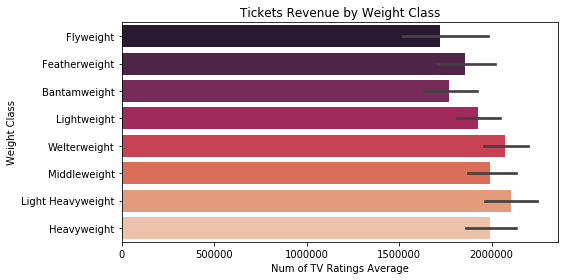

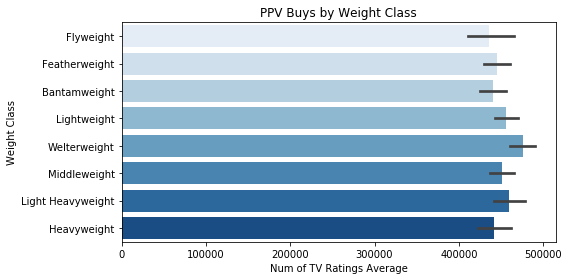

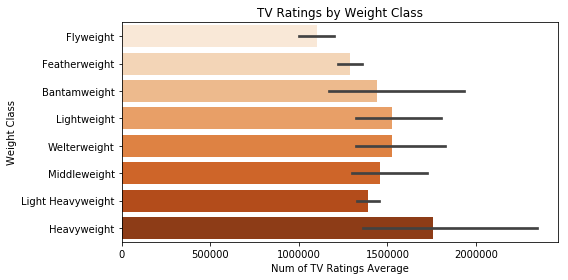

In [31]:
createRevenueGraphByWeightClass('tickets_revenue', False)
createRevenueGraphByWeightClass('ppv_buys', False)
createRevenueGraphByWeightClass('tv_ratings_avg', False)

### We can observe an overall trend, although not by much, of higher Popularity and Revenue scores for Heavier Weight Classes
Now let's create the graphs for **Title Bout Matches only**

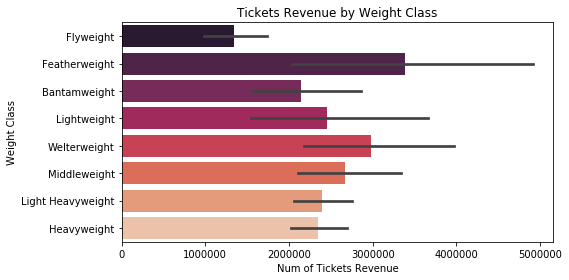

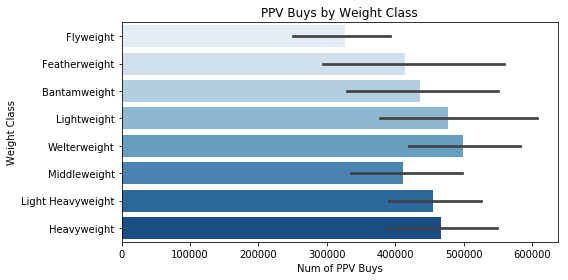

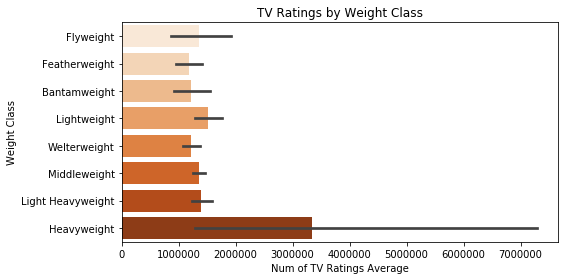

In [32]:
createRevenueGraphByWeightClass('tickets_revenue', True)
createRevenueGraphByWeightClass('ppv_buys', True)
createRevenueGraphByWeightClass('tv_ratings_avg', True)

## At Title Bout Matches some of the results may seem ambiguous, let's break it down:
## A. Tickets Revenue:
>Featherweight got the highest score, which is somewhat counter intuitive and explaning this will ןnvolve some speculations which I'm not sure if I'll be able to proove. <br>

**So let's generalize the Weight Classes to 2 halfs, lighter and heavier parts, and check to see which part got a greater score as a whole:**

In [33]:
def getTotalRateByWeightClassesGeneralized(df, rate):
    wc_lighterHalf = ['Flyweight','Featherweight','Bantamweight','Lightweight']
    wc_heavierHalf = ['Welterweight','Middleweight','Light Heavyweight','Heavyweight']

    wc_lighterHalf_totalTR = 0
    wc_heavierHalf_totalTR = 0

    for lightClass, heavyClass in zip(wc_lighterHalf, wc_heavierHalf):

        buff_df = df.loc[df.weight_class == lightClass]
        wc_lighterHalf_totalTR += buff_df[rate].sum()

        buff_df = df.loc[df.weight_class == heavyClass]
        wc_heavierHalf_totalTR += buff_df[rate].sum()

    print('Lighter Weight Classes total ',   rate, ': ', round(wc_lighterHalf_totalTR))
    print('Heavier Weight Classes total ',   rate, ': ', round(wc_heavierHalf_totalTR))

In [34]:
getTotalRateByWeightClassesGeneralized(eventsByWeightClasses_TBs, 'tickets_revenue')

Lighter Weight Classes total  tickets_revenue :  225114554.0
Heavier Weight Classes total  tickets_revenue :  444374148.0


## B.PPV Buys:

In [35]:
getTotalRateByWeightClassesGeneralized(eventsByWeightClasses_TBs, 'ppv_buys')

Lighter Weight Classes total  ppv_buys :  40209196.0
Heavier Weight Classes total  ppv_buys :  78664877.0


## C.TV Ratings:

In [36]:
getTotalRateByWeightClassesGeneralized(eventsByWeightClasses_TBs, 'tv_ratings_avg')

Lighter Weight Classes total  tv_ratings_avg :  126295527.0
Heavier Weight Classes total  tv_ratings_avg :  316581922.0


## Now it's clear that the trend of higher Popularity and Revenue rates to Heavier Weight Classes remains also in Title Bout Matches.

# 2. UFC's Revenues from tickets,  PPV buys and TV Ratings, through the career of the 3 of it's most remarkable Champions -  through different Weight Classes:

**1. Georges St-Pierre** - *Welterweight*
> - 1st place in Most wins in UFC (as was shown in graph earlier in the project)<br>

**2. Anderson Silva** - *Middleweight* 
> - which was introduced already - 3rd place in Most wins<br>
- Also fought at Lightheavyweight but not as a champion or a contendor

**3. Jon Jones** - *Lightheavyweight*
> - 4rd place in Most wins<br>

![the3Champions](https://researchinmma.files.wordpress.com/2017/12/jonesgspsilva.jpg)

                    Jon Jones to the left, Silva at the center and George St-Pierre to the right

## Let's Create a function that will create for a given Athlete an Event Statistics DataFrame:

1. We'll create a new DataFrame that's based on the UFC_df, gathering from there all the Athlete's matches as <br>
Red or Blue corner, the events details such as location and if the match was a title bout, all other irrelevant data will be excluded. <br>

2. We'll Merge it with the new scraped data of UFC Events Statistics

In [37]:
def createAthletesEventsStats_DF(athletesName, UFC_DF, UFC_Events_Revenue_DF):
    
    ## Based on project first part Dataset - UFC_df - Events details (R_Fighter, B_Fighter, Title_bout ect..)
    
    # Data 2 be excluded
    cols2Drop = list(UFC_df.columns.values)
    cols2Include = ['R_fighter', 'B_fighter', 'date', 'title_bout','weight_class']
    
    for col in cols2Include:
        cols2Drop.remove(col)

    # Assigning targeted data using loc to new Athlete dedicated DF - From Red Corner Matches
    athlete_R = UFC_df.loc[UFC_df['R_fighter'] == athletesName]

    # Droping all Red Corners irrelevant Data
    athlete_R = athlete_R.drop(columns = cols2Drop)

    # Again, now from Blue Corner Matches
    athlete_B = UFC_df.loc[UFC_df['B_fighter'] == athletesName]

    # Droping all Blue Corners irrelevant Data 
    athlete_B = athlete_B.drop(columns = cols2Drop)

    # Concat the two dfs into one 
    athletesDF = pd.concat([athlete_R, athlete_B], sort=False)

    
    
    ## Merging it with the new scraped data - Event's Statistics (Ticket's Revenu, PPV buys ect..)

    
    # Merge the 2 dfs
    athletes_eventsStats = pd.merge(athletesDF, UFC_Events_Revenue_DF, on='date')

    # Sort rows by date
    athletes_eventsStats = athletes_eventsStats.sort_values(by='date',ascending=False)

    # Rearrange columns order
    athletes_eventsStats = athletes_eventsStats[['date','R_fighter','B_fighter', 'weight_class','title_bout', 'attendance','tickets_revenue','ppv_buys','tv_ratings_avg']]

    return athletes_eventsStats

In [38]:
# Create the scraped data DataFrame using the function
andersonSilva_eventsStats_df = createAthletesEventsStats_DF('Anderson Silva', UFC_df, UFC_EventsRevenue_df)

andersonSilva_eventsStats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 20 to 19
Data columns (total 9 columns):
date               24 non-null object
R_fighter          24 non-null object
B_fighter          24 non-null object
weight_class       24 non-null object
title_bout         24 non-null bool
attendance         23 non-null float64
tickets_revenue    22 non-null float64
ppv_buys           20 non-null float64
tv_ratings_avg     8 non-null float64
dtypes: bool(1), float64(4), object(4)
memory usage: 1.7+ KB


Since Attendance, Ticket Revenue and PPV buys data is mostly there, We will **fill the NaN values with the column's mean**. <br>
As for TV Ratings, since it missing for the most part, We will leave that aside.

In [39]:
# Filling the below columns NaN values with it's mean
andersonSilva_eventsStats_df['tickets_revenue'].fillna((andersonSilva_eventsStats_df['tickets_revenue'].mean()), inplace=True)
andersonSilva_eventsStats_df['ppv_buys'].fillna((andersonSilva_eventsStats_df['ppv_buys'].mean()), inplace=True)
andersonSilva_eventsStats_df['attendance'].fillna((andersonSilva_eventsStats_df['attendance'].mean()), inplace=True)

andersonSilva_eventsStats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 20 to 19
Data columns (total 9 columns):
date               24 non-null object
R_fighter          24 non-null object
B_fighter          24 non-null object
weight_class       24 non-null object
title_bout         24 non-null bool
attendance         24 non-null float64
tickets_revenue    24 non-null float64
ppv_buys           24 non-null float64
tv_ratings_avg     8 non-null float64
dtypes: bool(1), float64(4), object(4)
memory usage: 1.7+ KB


In [40]:
andersonSilva_eventsStats_df.head()

,date,R_fighter,B_fighter,weight_class,title_bout,attendance,tickets_revenue,ppv_buys,tv_ratings_avg
20,2019-05-11,Jared Cannonier,Anderson Silva,Middleweight,False,15193.0,3357602.5,532200.0,813000.0
21,2019-02-09,Israel Adesanya,Anderson Silva,Middleweight,False,15238.0,2470088.0,175000.0,1340000.0
0,2017-02-11,Anderson Silva,Derek Brunson,Middleweight,False,15628.0,2275105.0,200000.0,874000.0
22,2016-07-09,Daniel Cormier,Anderson Silva,Light Heavyweight,False,18202.0,10700000.0,1009000.0,1790000.0
1,2016-02-27,Anderson Silva,Michael Bisping,Middleweight,False,16734.0,2000000.0,532200.0,NaN


In [41]:
jonJones_eventsStats_df = createAthletesEventsStats_DF('Jon Jones', UFC_df, UFC_EventsRevenue_df)

jonJones_eventsStats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 15
Data columns (total 9 columns):
date               20 non-null object
R_fighter          20 non-null object
B_fighter          20 non-null object
weight_class       20 non-null object
title_bout         20 non-null bool
attendance         19 non-null float64
tickets_revenue    19 non-null float64
ppv_buys           17 non-null float64
tv_ratings_avg     10 non-null float64
dtypes: bool(1), float64(4), object(4)
memory usage: 1.4+ KB


In [42]:
# Filling the below columns NaN values with it's mean
jonJones_eventsStats_df['tickets_revenue'].fillna((jonJones_eventsStats_df['tickets_revenue'].mean()), inplace=True)
jonJones_eventsStats_df['ppv_buys'].fillna((jonJones_eventsStats_df['ppv_buys'].mean()), inplace=True)
jonJones_eventsStats_df['attendance'].fillna((jonJones_eventsStats_df['attendance'].mean()), inplace=True)

# Making sure it's value's format stays none-scientific
pd.options.display.float_format = '{:.0f}'.format

jonJones_eventsStats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 15
Data columns (total 9 columns):
date               20 non-null object
R_fighter          20 non-null object
B_fighter          20 non-null object
weight_class       20 non-null object
title_bout         20 non-null bool
attendance         20 non-null float64
tickets_revenue    20 non-null float64
ppv_buys           20 non-null float64
tv_ratings_avg     10 non-null float64
dtypes: bool(1), float64(4), object(4)
memory usage: 1.4+ KB


In [43]:
jonJones_eventsStats_df.head()

,date,R_fighter,B_fighter,weight_class,title_bout,attendance,tickets_revenue,ppv_buys,tv_ratings_avg
0,2019-03-02,Jon Jones,Anthony Smith,Light Heavyweight,True,14790,4035156,650000,1480000
1,2018-12-29,Jon Jones,Alexander Gustafsson,Light Heavyweight,True,15862,2066604,700000,1150000
16,2017-07-29,Daniel Cormier,Jon Jones,Light Heavyweight,True,16610,2448870,860000,886000
2,2016-04-23,Jon Jones,Ovince Saint Preux,Light Heavyweight,True,11352,2300000,322000,835000
3,2015-01-03,Jon Jones,Daniel Cormier,Light Heavyweight,True,11575,3700000,800000,1040000


In [44]:
gSP_eventsStats_df = createAthletesEventsStats_DF('Georges St-Pierre', UFC_df, UFC_EventsRevenue_df)

gSP_eventsStats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 19 to 18
Data columns (total 9 columns):
date               22 non-null object
R_fighter          22 non-null object
B_fighter          22 non-null object
weight_class       22 non-null object
title_bout         22 non-null bool
attendance         22 non-null float64
tickets_revenue    21 non-null float64
ppv_buys           20 non-null float64
tv_ratings_avg     4 non-null float64
dtypes: bool(1), float64(4), object(4)
memory usage: 1.6+ KB


In [45]:
# Filling the below columns NaN values with it's mean
gSP_eventsStats_df['tickets_revenue'].fillna((gSP_eventsStats_df['tickets_revenue'].mean()), inplace=True)
gSP_eventsStats_df['ppv_buys'].fillna((gSP_eventsStats_df['ppv_buys'].mean()), inplace=True)

# Making sure it's value's format stays none-scientific
pd.options.display.float_format = '{:.0f}'.format

gSP_eventsStats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 19 to 18
Data columns (total 9 columns):
date               22 non-null object
R_fighter          22 non-null object
B_fighter          22 non-null object
weight_class       22 non-null object
title_bout         22 non-null bool
attendance         22 non-null float64
tickets_revenue    22 non-null float64
ppv_buys           22 non-null float64
tv_ratings_avg     4 non-null float64
dtypes: bool(1), float64(4), object(4)
memory usage: 1.6+ KB


In [46]:
gSP_eventsStats_df.head()

,date,R_fighter,B_fighter,weight_class,title_bout,attendance,tickets_revenue,ppv_buys,tv_ratings_avg
19,2017-11-04,Michael Bisping,Georges St-Pierre,Middleweight,True,18000,6105306,875000,1280000
0,2013-11-16,Georges St-Pierre,Johny Hendricks,Welterweight,True,14856,5759000,630000,998000
1,2013-03-16,Georges St-Pierre,Nick Diaz,Welterweight,True,20145,3710000,950000,nan
2,2012-11-17,Georges St-Pierre,Carlos Condit,Welterweight,True,17249,3143000,700000,nan
3,2011-04-30,Georges St-Pierre,Jake Shields,Welterweight,True,55724,12075000,800000,nan


# UFC Event Structure
is assembled out of 2 parts: **'Main card'** and **'Perliminary card'**. <br>
The main card has 3 matches:
1. Main Event
2. Co-main Event
3. **Title Bout**

**We assume that the main card matches are at the center of the event's popularity**, therfore a further assumption is that **it has the more influence over the Event's Popularity therefore also on Revenues, for tickets and PayPerView buys.** <br>
And following that assumed logic, a Title Bout should have a greater influence over the Main Event or Co-Main Event<br>
**It is a general assumption, and it is clear that there are exceptions,** in which the Co-Main\Main Event could be a greater factor on Popularity and Revenues, **for example, in cases which the Athletes that's taking part in a Co-Main\Main Event Match is much more popular than the Athletes fighting in Title Bout Match.**<br> <br>

## Let's create a graph of the 3 champions careers, in terms of Tickets Revenue and PPV buys.<br>

As a direvative of the above assumption, it is possible to further assume that the 3 Champions's influence share over popularity and revenue of the events they participated in, was greatly bigger as Contendors or Champions (of a weight class), rather than in thier early career.<br>

**For that reason, and so We can observe the differences, We'll mark all title bout matcheses dates in green, with darker shade to their first one.**<br>
<br>

### Let's create a function that generates the graph for each champion:

In [47]:
def createAthletesEventsStatsGraph(athletes_df, athletesName):
    
    # New df instance with Ascending sortaion by date:
    athletes_asc = athletes_df.sort_values(by='date',ascending=True)
    
    # Using loc, creating a new df including only title bouts
    allTitleBouts = athletes_asc.loc[athletes_asc['title_bout'] == True]
    # Taking out the first title bout
    firstTitleBout = allTitleBouts.loc[allTitleBouts['date'] == min(allTitleBouts['date'])]
    # Converting both to lists
    firstTitleBout_list = firstTitleBout.date.values.tolist()
    allTitleBouts_list = allTitleBouts.date.values.tolist()
    # Removing the first from the rest of the title bouts
    allTitleBouts_list.remove(firstTitleBout_list[0])

    
    # Defining 1st axis and figure size:
    fig, ax  = plt.subplots(figsize=(12,6))
    # Defining Ticket's Revenue Line:
    eventsRevenueLine = sns.lineplot(x='date',y='tickets_revenue', color='blue', data=athletes_asc, ax=ax, linewidth=3.5)

    # Defining 2nd axis:
    eventsPpvLine = ax.twinx()
    # Defining PPV buys line:
    sns.lineplot(x='date',y='ppv_buys', data=athletes_asc, ax=eventsPpvLine, color='orange', linewidth=1)
    
    
    # Setting graph's title
    plt.title("Tickets Revenu and PPV buys throughtout Athlete's Career in UFC")
    # Positioning the Athletes name on the top left corner of the 1st axis
    ax.text(0.02, 0.98, athletesName, fontsize=15, ha="left", va="top", transform=ax.transAxes)
    # Positioning text - Green color for title bouts
    ax.text(0.98, 0.98, 'Green Date = Title Bout', fontsize=10, color='limegreen', ha="right", va="top", transform=ax.transAxes)
    # Setting 1st and 2nd axes x and y labels
    ax.set_ylabel('Tickets Revenu', color='blue', fontsize=10)
    eventsPpvLine.set_ylabel('PPV Buys', color='orange', fontsize=10)
    ax.set_xlabel('Date')
    
    # Preventing scientific exponential format, so it'll be readble:
    ax.yaxis.get_major_formatter().set_scientific(False)
    
    # Drawing the plot so the xticks will get populated from data frame, so we can change color in the next loop
    plt.draw()
    
    
    for tick in ax.get_xticklabels():
        
        # Rotate Date tick labels, so it's readable:
        tick.set_rotation(60)
        
         # If date is the first title bout match - Set to dark green and bigger size
        if tick.get_text() in firstTitleBout_list:
            tick.set_color('mediumseagreen')
            tick.set_fontsize(15)
        
        # If date is another title bout match - Set to light green 
        elif tick.get_text() in allTitleBouts_list:
            tick.set_color("limegreen")
        
    plt.tight_layout()

    eventsRevenueLine

## Before we plot the graphs,
## Let's take a look what's the average score of an UFC event - In terms of Revenue, <br> So We have a perspective to the graphs values of the 3 Champions

In [48]:
ufcEvent_TicketsRevenueAverage = UFC_EventsRevenue_df['tickets_revenue'].mean()
ufcEvent_PpvBuysAverage = UFC_EventsRevenue_df['ppv_buys'].mean()
print('UFC Event average Tickets Revenue:' , '\n', round(ufcEvent_TicketsRevenueAverage), '\n')
print('UFC Event average PayPerView buys:', '\n', round(ufcEvent_PpvBuysAverage))

UFC Event average Tickets Revenue: 
 2020983.0 

UFC Event average PayPerView buys: 
 444598.0


**Now let's see the Champions graphs:**

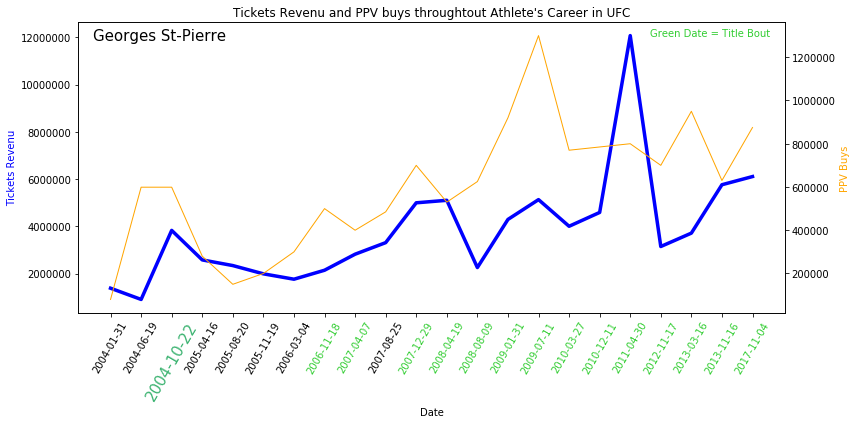

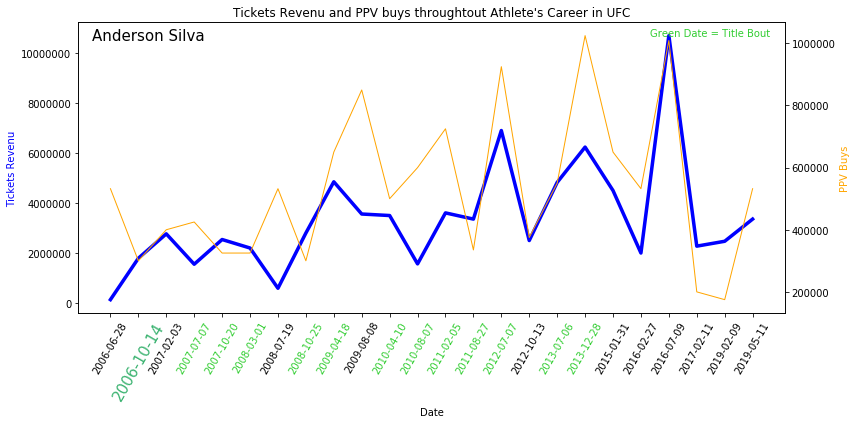

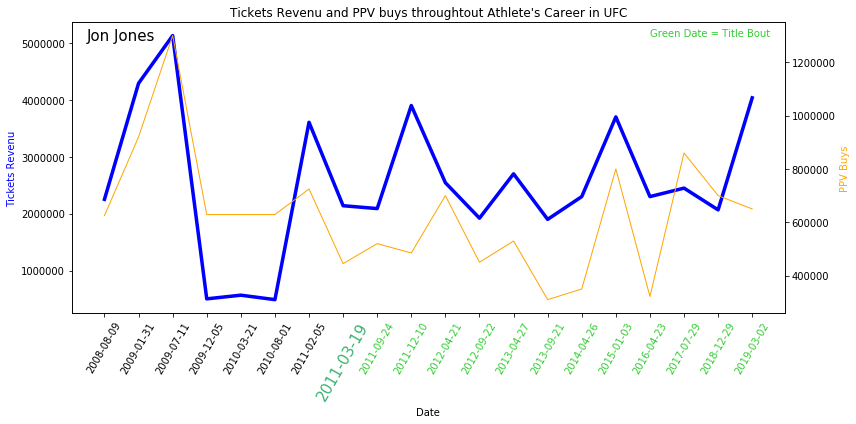

In [49]:
createAthletesEventsStatsGraph(gSP_eventsStats_df, 'Georges St-Pierre')
createAthletesEventsStatsGraph(andersonSilva_eventsStats_df, 'Anderson Silva')
createAthletesEventsStatsGraph(jonJones_eventsStats_df, 'Jon Jones')

## **Georges St-Pierre** - <br>

> A.  **The relativly high PPV score** of the his 2nd match ever (before he fought as a contendor), **is maybe not should be related to him.**<br><br>
B. We can observe the bump in scores in his first time as a contendor, which We can tell he lost this shot.<br>
After that, it's easy to see the **incline in scores, which pretty much only grew with time, in linear fashion.**<br><br>
C. He won 13/15 tite bouts overall<br><br>
D.  There is a match (19-4-2008) where the **PPV Buys rate are inclining but the Tickets Revenue declining** in relation to the previous match.<br><br>
E. **Through most of St-Pierre's graph, visually it seems like the two rates lines are correlated - despite the difference in the rates ratios.**

Let's calculate the relation of Georges St-Pierre's average rates to the UFC general averages:

In [50]:
gSP_TicketsRevenueAverage = gSP_eventsStats_df['tickets_revenue'].mean()
gSP_PpvBuysAverage = gSP_eventsStats_df['ppv_buys'].mean()


diff = [(((gSP_TicketsRevenueAverage-ufcEvent_TicketsRevenueAverage)/ufcEvent_TicketsRevenueAverage)*100),(((gSP_PpvBuysAverage-ufcEvent_PpvBuysAverage)/ufcEvent_PpvBuysAverage)*100)]
print('Differnce between an average UFC event Revenue scores to An Event with George St-Pierre preforming:', '\n')
print('Tickets Revenue: An increase of: ' , round(diff[0]) , '% from the average')
print('PPV Buys: An increase of: ' , round(diff[1]) , '% from the average', '\n')

Differnce between an average UFC event Revenue scores to An Event with George St-Pierre preforming: 

Tickets Revenue: An increase of:  89.0 % from the average
PPV Buys: An increase of:  35.0 % from the average 



##  Anderson Silva - <br>

> A. We can see that he is also, **like George St-Pierre, lost his first title bout shot.**<br><br>
B.  Also here at Silva's graph there are matches where **the 2 rates, in some events even not correlated.**<br><br>
C. Silva's trend of incline in scores is not displayed as clear as in George's St-Pierre's graph - **where even as a champion, some of his matches got scores which are relatively close to the average, or worst**, but also, he defenately got some extreme peaks above the general UFC averages.<br><br>
D. **Also here, at Silva's graph - there are parts in which the correlation between the 2 rates is visualized -  despite the difference of the rates ratios.**<br><br>

**So let's calculate Silva's average scores incline from the UFC general averages**:

In [51]:
Silvas_TicketsRevenueAverage = andersonSilva_eventsStats_df['tickets_revenue'].mean()
Silvas_PpvBuysAverage = andersonSilva_eventsStats_df['ppv_buys'].mean()


diff = [(((Silvas_TicketsRevenueAverage-ufcEvent_TicketsRevenueAverage)/ufcEvent_TicketsRevenueAverage)*100),(((Silvas_PpvBuysAverage-ufcEvent_PpvBuysAverage)/ufcEvent_PpvBuysAverage)*100)]
print('Differnce between an average UFC event Revenue scores to An Event with Anderson Silva preforming:', '\n')
print('Tickets Revenue: An increase of: ' , round(diff[0]) , '% from the average')
print('PPV Buys: An increase of: ' , round(diff[1]) , '% from the average', '\n')

Differnce between an average UFC event Revenue scores to An Event with Anderson Silva preforming: 

Tickets Revenue: An increase of:  66.0 % from the average
PPV Buys: An increase of:  20.0 % from the average 



## Jone Jones - <br><br>

> A. His graph is **visually splitted by the dates into 2 parts**, since he won he's first title bout and never lost it.<br><br>
B. We can see a huge bumps at the rates at his first matches, before he was a contendor, maybe it's not to be related to him.<br><br>
C. Since he is a Champion hes rates are in dramatic rise and falls, no linear incline trend, even it seems somewhat overall balanced.<br><br>
D. **Also at Jones graph, through almost the whole it, the correlation between the 2 rates is clearly visualized - despite the difference of the rates ratios.**<br><br>

**let's calculate Jon's average scores incline from the UFC general averages**:

In [52]:
jones_TicketsRevenueAverage = jonJones_eventsStats_df['tickets_revenue'].mean()
jones_PpvBuysAverage = jonJones_eventsStats_df['ppv_buys'].mean()


diff = [(((jones_TicketsRevenueAverage-ufcEvent_TicketsRevenueAverage)/ufcEvent_TicketsRevenueAverage)*100),(((jones_PpvBuysAverage-ufcEvent_PpvBuysAverage)/ufcEvent_PpvBuysAverage)*100)]
print('Differnce between an average UFC event Revenue scores to An Event with Jone Jones preforming:', '\n')
print('Tickets Revenue: An increase of: ' , round(diff[0]) , '% from the average')
print('PPV Buys: An increase of: ' , round(diff[1]) , '% from the average', '\n')

Differnce between an average UFC event Revenue scores to An Event with Jone Jones preforming: 

Tickets Revenue: An increase of:  26.0 % from the average
PPV Buys: An increase of:  41.0 % from the average 



# Conclusion:

**These 3 guys holds a unique positions in the UFC franchise:**<Br><br>
**1.** 3 of them are in the **top 5 UFC athletes with most wins**. (Graph in Part 1)<br>
**2.** 3 of them are in the **top longest Title Reign** - not a passing phenomena.<br><br>

These facts clearly **translates into Popularity and eventually Revenue** for the UFC franchise - <br>
**With incline of 20 - 89% (in both rates) from the average UFC event rates** for these 3 champions, **We can understand the tremendous value these longtime champions are bringing to the UFC franchise**

## 3. Calculating the Total Revenue each Champion has produced for the UFC:
### For that We'll use the manual scraped data of PPV average prices over the years - 
Let's create a function that generates a new DataFrame with the sum of all<br>
Tickets Revenue and PPV Buys:

In [53]:
def createDF_TotalRevenueByChampion(athletes_dfs_list, namesList):
    
    dictBuffer = []
    
    for athlete_df, name in zip(athletes_dfs_list, names):
        
        # Dictionary buffer for each athlete
        totalRevenu_dict = dict()
        totalRevenu_dict['name'] = name
        totalRevenu_dict['total_tickets_revenue'] = athlete_df['tickets_revenue'].sum()
        totalRevenu_dict['total_ppv_revenue'] = 0
    
        # Appending to list of dicts
        dictBuffer.append(totalRevenu_dict)
    
    # Converting to DataFrame
    champions_TotalRevenu = pd.DataFrame(dictBuffer)
    
    return champions_TotalRevenu

Let's use the function

In [54]:
listOfAthletes_dfs = [andersonSilva_eventsStats_df, gSP_eventsStats_df, jonJones_eventsStats_df]
names = ['Anderson Silva', 'George St-Pierre', 'Jone Jones']

# Creating the Total DF using the above function
DF_TotalRevenueByChampion = createDF_TotalRevenueByChampion(listOfAthletes_dfs, names)

DF_TotalRevenueByChampion.head()

,name,total_ppv_revenue,total_tickets_revenue
0,Anderson Silva,0,80582460
1,George St-Pierre,0,84165286
2,Jone Jones,0,50883000


## Now let's calculate the Total PayPerView Revenue for each Champion - Using the average prices over the years

Let's create a function:

In [55]:
# The fucntion takes: name and the DF of the athlete, PPV avg prices - list of tuples, and the DF to insert the outcome
def calc2DF_PpvTotalRevenue(name_, atheletes_df, ppvPrices, atheletes_totalRevenue_df):
    
    # Taking out from the athlete's df the event's year and PPV Buy rate
    Athletes_ppvBuys = []
    for i, row in atheletes_df.iterrows():
        Athletes_ppvBuys.append([row['date'].split('-')[0], row['ppv_buys']])
    
    # Calculating each event PPV Revenue with the Avg prices
    sumOfRevenue = 0
    for rate in ppvPrices:
        for event in Athletes_ppvBuys:
            if rate[0] == event[0]:
                sumOfRevenue += (rate[1] * event[1])
                
    # Assigning the sum to the athlete's DF
    atheletes_totalRevenue_df.loc[atheletes_totalRevenue_df.name == name_, 'total_ppv_revenue'] = sumOfRevenue

Let's use the function and calculate the total revenue per athlete, combining the 2 rates:

In [56]:
calc2DF_PpvTotalRevenue('Anderson Silva', andersonSilva_eventsStats_df, ppvAvgPrice, DF_TotalRevenueByChampion)
calc2DF_PpvTotalRevenue('George St-Pierre', gSP_eventsStats_df, ppvAvgPrice, DF_TotalRevenueByChampion)
calc2DF_PpvTotalRevenue('Jone Jones', jonJones_eventsStats_df, ppvAvgPrice, DF_TotalRevenueByChampion)

DF_TotalRevenueByChampion['total_revenue'] = DF_TotalRevenueByChampion['total_ppv_revenue'] + DF_TotalRevenueByChampion['total_tickets_revenue']

DF_TotalRevenueByChampion

,name,total_ppv_revenue,total_tickets_revenue,total_revenue
0,Anderson Silva,633705952,80582460,714288412
1,George St-Pierre,604734700,84165286,688899986
2,Jone Jones,648061001,50883000,698944001


### Let's plot a bars chart and visualize the results:
Let's create a function:

In [57]:
def totalRevenuePerChampGraph(df, rate):
    fig, ax = plt.subplots(figsize=(10,4))
    totalRevenuePerChamp = sns.barplot(x=df[rate], y=df.name, palette="RdBu_r")
    
    ax.xaxis.get_major_formatter().set_scientific(False)
    
    plt.xticks(rotation=60)

    plt.title("Total Revenue")
    plt.ylabel('Champion')
    
    if rate is 'total_ppv_revenue':
        plt.title('PayPerView Buys Total Revenue')
        plt.xlabel("Total Revenue in $")
    if rate is 'total_tickets_revenue':
        plt.title('Tickets Total Revenue')
        plt.xlabel("Total Revenue in $")
    if rate is 'total_revenue':
        plt.title('Total Revenue (Tickets + PPV)')
        plt.xlabel("Total Revenue in $")


    totalRevenuePerChamp


and generate the graphs using it:

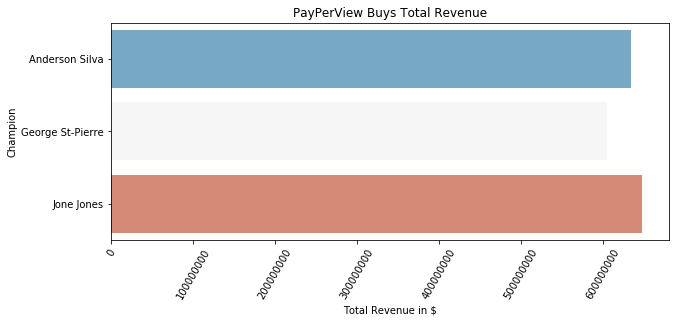

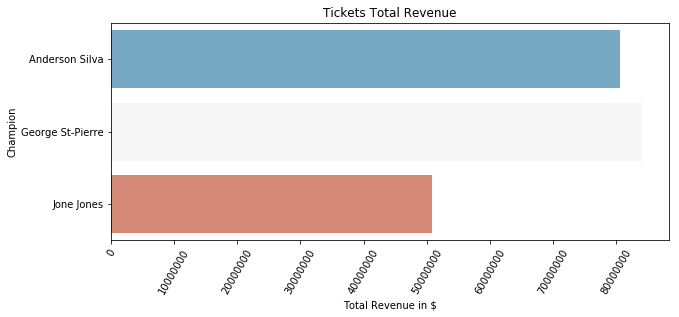

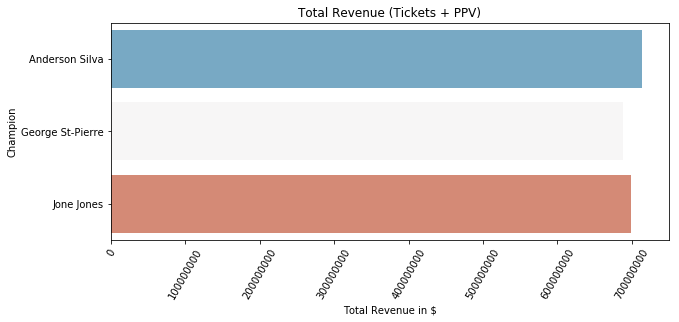

In [58]:
rates = ["total_ppv_revenue", "total_tickets_revenue", "total_revenue"]

for rate in rates:
    totalRevenuePerChampGraph(DF_TotalRevenueByChampion, rate) 

## Let's break it down:

### A. PayPerView Buys Total Revenue:
1. **Jon Jones** - with **over 648,000,000 Miliion USD**
>This is quite surprising when looking back at the career graphs, where it seems like Jones is not necessarily brining a constant higher PVV Buys rate. But looking into the matches dates, it indicates that this might be the reason.<br>
**Overall his whole career is more in the near past** than St-Pierre or Silva.<br>
**Combining this with the UFC's PPV rising prices over the years** (which can be viewed in the tuples list) - **it makes sense.**
2. **Anderson Silva** - not by much less
3. **George St-Pierre** - above $600M

### B. Tickets Total Revenue:
1. **George St-Pierre** - above $80 Million USD
2. **Anderson Silva** - not by much less
3. **Jon Jones** - 'only' over 50 Miliion USD


## C. Total Revenue (Tickets + PPV):
1. **Anderson Silva -  with over 700,000,000 Miliion USD**
2. **Jon Jones** - not by much less than Silva
3. **George St-Pierre** - not by much less than Jones

### Combined, on the Events they all took part in, the UFC has cashed out on over **$2 Billion.** <br>

**Note**: In 2016, the UFC Franchise has been sold for $4 Billion.

## 4. The Champions Networth
After seeing the profits the UFC has gained in the events which they competed in, let's see how these 3 Champions is doing financially - <br>
**Using the Top 50 MMA Athletes by Networth data we scraped earlier:**

In [59]:
champions = ['Anderson Silva', 'Jon Jones', 'Georges St Pierre']
champions_InTop50MMA_df = pd.DataFrame(columns=['rank','name','networth'])

# If champion found in top50 DF, append to new DF, if not found print a message
for champion in champions:
    networth_ = top50_AthletesNetworth_df.loc[top50_AthletesNetworth_df['name'] == champion]
    if networth_.empty:
        print("ATHLETE NOT FOUND IN LIST: ", champion,'\n')
    else:
        champions_InTop50MMA_df = champions_InTop50MMA_df.append([networth_], ignore_index=False, verify_integrity=False, sort=None)


ATHLETE NOT FOUND IN LIST:  Jon Jones 



In [63]:
champions_InTop50MMA_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 7 to 2
Data columns (total 3 columns):
rank        2 non-null object
name        2 non-null object
networth    2 non-null float64
dtypes: float64(1), object(2)
memory usage: 144.0+ bytes


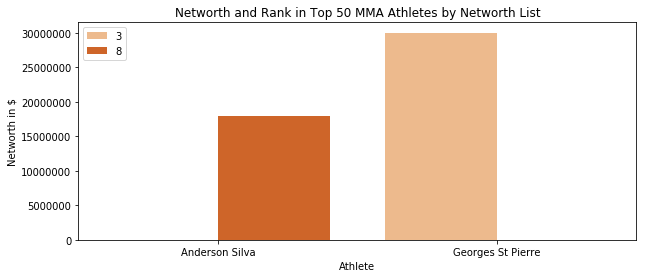

In [61]:
fig, ax = plt.subplots(figsize=(10,4))
ChampsNetworth = sns.barplot(y='networth', x='name' , data=champions_InTop50MMA_df, hue='rank', palette="Oranges")

ax.yaxis.get_major_formatter().set_scientific(False)

plt.legend(loc='upper left')
plt.title("Networth and Rank in Top 50 MMA Athletes by Networth List")
plt.xlabel("Athlete")
plt.ylabel("Networth in $")

ChampsNetworth

**Surprisingly enough, Jone Jones is not even in the list, let's see what number ends the Top 50 list:**

In [62]:
minNetworth = top50_AthletesNetworth_df.networth.loc[top50_AthletesNetworth_df.networth == top50_AthletesNetworth_df.networth.min()]
minNetworth

43   4000000
44   4000000
45   4000000
46   4000000
47   4000000
48   4000000
49   4000000
Name: networth, dtype: float64

So due to that list, **Jones has no more of $4M at best.** <br>
**Note:**<br>
This list is not updated as a whole, and some of atheltes info was updated in 2020,
and for some the last update date isn't mentioned

### Wrapping up:
1. **Georges St-Pierre** with **30 Million USD** - Ranked **#3** in Top 50 MMA athletes by Networth list
2. **Anderson Silva** with **18 Million USD** - Ranked **#8** in Top 50 MMA athletes by Networth list
3. **Jone Jones** - unknown 

# Section 3 - 

## 1. Summary:

1. **UFC Events Popularity Revenue by the Different Weight Classes** 
> Although it wasn't completely clear by the visualization, We saw that **the heavier weight classes are more popular and produced more revenue** to the UFC. 

2. **UFC's Revenue from Tickets and PPV buys, through the career of 3 Champions - through different Weight Classes**
> Altough the graphs of the 3 Champions careers didn't look exactly the same, 2 of them got a (different) kind of visual incline trend along the time axis - George St-Pierre's, and Anderson Silvas. At Jone Jone's We saw some overall stability through the whole career.<br>
**At the 3 graphs there was, altought in different degrees, a visualized correlation between the two rates - PPV buys rate (which is not PPV revenue), and Tickets Revenue.**

3. **Calculating the Total Revenue each Champion has produced for the UFC**
>After calculating the revenue out of the PPV buys - with the manual scraped data of PPV averge prices over the years, We could calculate the total revenu per champion.<br>
**Each one of them came up with more than 600 Million USD with Anderson Silva leading with over $700 Million.**<br>
Combined, they came up with more than 2 Billion USD in revenue for the UFC.<br>
Also, We saw that **each one was leading in different criteria** - with Jones leading the Total PPV revenue - thanks to the PPV rising prices over the years, St-Pierre leading the Total Tickets revenue, and Silva leading the Total of both PPV and Tickets revenue.

4. **The Champions Networth**
>Using the Top 50 MMA Athletes by Networth, We saw that George St-Pierre is leading, ranked #3 with 30 Million USD.<br>
Silva at the 2nd place, ranked #8 at the list with 18 Million USD.<br>
**Surprisingly, despite the large numbers of Revenue Jones has generated to the UFC, he wasn't found at the list**,<br>
which is closed by the Networth of 4 Million USD.

5. **Attendance data**
>The Attendance data was also scraped along with the Popularity and Revenue data, but was not used, due to lack of clarity regarding it's proper use.<br>
Besides the fact that there are multiple types of tickets in a big price range,<br>
Also dividing the Tickets Revenue by the Attendance, would not necessarily give a true sense of the avergae ticket price per event - One reason would be that it is known that the UFC is giving out free tickets for Celebrities, Influencers and Books men, also, the UFC, which is an American franchise, is being hosted not only at the U.S, so the location would be another factor of the precentage of give outs tikcets - which I don't know how to evaluate.

## 2. Writing the scraped data to csv files

In [64]:
UFC_EventsRevenue_df.to_csv('./UFC_Events_Revenue_Statistics.csv', index = False,  encoding='utf-8')

top50_AthletesNetworth_df.to_csv('./top50_MMA_Athletes_By_Networth.csv', index = False, encoding='utf-8')